# Pre-processing

Il seguente codice estare un farme, verifica la qualità tramite Variance of Laplacian, ridimensiona e converte il frame per la compatibilità con modelli PyTorch/Stable Diffusion

In [ ]:
import cv2
import os
import numpy as np

# === Parametri ===
video_path = "video/2024_09_19__12_14_01.ts"
output_dir = "video/frames_preprocessed"
os.makedirs(output_dir, exist_ok=True)

interval = 30  # Estrai un frame ogni 30
resize_width = 1024
resize_height = 576
laplacian_threshold = 100  # Soglia di nitidezza minima

# === Apertura video ===
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Errore: impossibile aprire il video.")
    exit()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Totale frame: {frame_count} | FPS: {fps}")

frame_index = 0
saved_frames = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Estrai solo ogni N frame
    if frame_index % interval == 0:
        # Calcola nitidezza
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

        if laplacian_var >= laplacian_threshold:
            # Ridimensionamento mantenendo l'aspect ratio
            frame_resized = cv2.resize(frame, (resize_width, resize_height), interpolation=cv2.INTER_AREA)

            # Conversione da BGR a RGB
            frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

            # Normalizzazione (range [0, 1])
            frame_normalized = frame_rgb.astype(np.float32) / 255.0

            # Salvataggio in JPG del frame originale (opzionale)
            output_path = os.path.join(output_dir, f"frame_{frame_index}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor((frame_normalized * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            print(f"Frame {frame_index} salvato (VarLap = {laplacian_var:.2f})")

            saved_frames += 1

    frame_index += 1

cap.release()
print(f"Totale frame validi salvati: {saved_frames}")


# Inpainting


In [4]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import pandas as pd

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline_optimized as pipeline

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = DEVICE == "cuda"
USE_TORCH_COMPILE = DEVICE == "cuda" and hasattr(torch, 'compile')
COMPILE_MODE = "reduce-overhead"
N_INFERENCE_STEPS = 20
BATCH_SIZE_INPAINT = 4

print(f"[INFO] Using device: {DEVICE}")
print(f"[INFO] Using FP16 precision: {USE_FP16}")
print(f"[INFO] Using torch.compile: {USE_TORCH_COMPILE} (mode: {COMPILE_MODE})")
print(f"[INFO] Inpainting steps: {N_INFERENCE_STEPS}, batch size: {BATCH_SIZE_INPAINT}")

# === Paths ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting_optimized.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_optimized_1.csv"
MODEL_DATA_DIR = "../data"
YOLO_MODEL_PATH = "yolov8x-seg.pt"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

# === Load models ===
print("[INFO] Loading models...")
tokenizer = CLIPTokenizer(
    os.path.join(MODEL_DATA_DIR, "vocab.json"),
    merges_file=os.path.join(MODEL_DATA_DIR, "merges.txt")
)
model_file = os.path.join(MODEL_DATA_DIR, "v1-5-pruned-emaonly.ckpt")
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model checkpoint not found at {model_file}")

models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

for model_name in models:
    model = models[model_name]
    if model is not None:
        model.to(DEVICE)
        if USE_FP16:
            model.half()
        if USE_TORCH_COMPILE and model_name in ["encoder", "diffusion", "decoder"]:
            try:
                print(f"[INFO] Compiling {model_name}...")
                models[model_name] = torch.compile(model, mode=COMPILE_MODE)
            except Exception as e:
                print(f"[WARNING] Could not compile {model_name}: {e}")

# === Load image ===
if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === YOLOv8 segmentation ===
print("[INFO] Running YOLOv8 segmentation...")
if not os.path.exists(YOLO_MODEL_PATH):
    raise FileNotFoundError(f"YOLO model not found at {YOLO_MODEL_PATH}")
yolo_model = YOLO(YOLO_MODEL_PATH)
start_yolo = time.time()
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0
all_crops_data = []

for result in results:
    if result.masks is None:
        continue

    boxes = result.boxes
    masks_yolo = result.masks

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks_yolo.data[i].cpu().numpy().astype(np.uint8)
        mask_resized_full = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(mask_resized_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled_full_for_crop = np.zeros_like(mask_resized_full)
        cv2.drawContours(mask_filled_full_for_crop, contours, -1, 255, thickness=cv2.FILLED)

        mask_crop_np = mask_filled_full_for_crop[y1:y2, x1:x2]
        if mask_crop_np.sum() / 255 < 200:
            continue

        crop_img_pil = original_img.crop((x1, y1, x2, y2))
        crop_mask_pil = Image.fromarray(mask_crop_np).convert("L")

        resized_img_pil = crop_img_pil.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask_pil = crop_mask_pil.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        all_crops_data.append({
            'input_image': resized_img_pil,
            'input_mask': resized_mask_pil,
            'prompt': prompt,
            'negative_prompt': negative_prompt,
            'coords': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'box_w': box_w, 'box_h': box_h},
            'original_crop_pil': crop_img_pil,
            'blend_mask_pil': Image.fromarray(mask_crop_np).convert("L")
        })

if all_crops_data:
    num_batches = (len(all_crops_data) + BATCH_SIZE_INPAINT - 1) // BATCH_SIZE_INPAINT
    print(f"[INFO] Processing {len(all_crops_data)} people in {num_batches} batches...")

    for batch_num in range(num_batches):
        batch_start_idx = batch_num * BATCH_SIZE_INPAINT
        batch_end_idx = min((batch_num + 1) * BATCH_SIZE_INPAINT, len(all_crops_data))
        current_batch_data = all_crops_data[batch_start_idx:batch_end_idx]

        batched_input_images = [item['input_image'] for item in current_batch_data]
        batched_input_masks = [item['input_mask'] for item in current_batch_data]
        batched_prompts = [item['prompt'] for item in current_batch_data]
        batched_neg_prompts = [item['negative_prompt'] for item in current_batch_data]

        start_inpaint = time.time()
        generated = pipeline.generate(
            prompt=batched_prompts,
            uncond_prompt=batched_neg_prompts,
            input_image=batched_input_images,
            input_mask=batched_input_masks,
            strength=0.4,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=N_INFERENCE_STEPS,
            seed=None,
            models=models,
            device=DEVICE,
            tokenizer=tokenizer,
            use_fp16=USE_FP16
        )
        inpaint_total_time += (time.time() - start_inpaint)

        for i, result_np in enumerate(generated):
            item_data = current_batch_data[i]
            result_pil = Image.fromarray(result_np)
            coords = item_data['coords']
            original_crop_pil = item_data['original_crop_pil']
            blend_mask_pil = item_data['blend_mask_pil']

            result_resized = result_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.LANCZOS)
            result_np = np.array(result_resized).astype(np.float32)
            original_np = np.array(original_crop_pil).astype(np.float32)

            blend_mask = np.array(blend_mask_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.NEAREST)).astype(np.float32) / 255.0
            blend_mask = np.expand_dims(blend_mask, axis=-1)

            blended = result_np * blend_mask + original_np * (1 - blend_mask)
            final_img_np[coords['y1']:coords['y2'], coords['x1']:coords['x2']] = blended.astype(np.uint8)
            crop_counter += 1
else:
    print("[INFO] No valid people found for inpainting.")

# === Save final output ===
final_img_pil = Image.fromarray(final_img_np)
final_img_pil.save(OUT_PATH)
print(f"[INFO] Output image saved to: {OUT_PATH}")

# === Save performance CSV ===
if crop_counter > 0:
    df_data = {
        "Modello": f"YOLOv8 + SD 1.5 (Steps:{N_INFERENCE_STEPS} FP16:{USE_FP16} Compile:{USE_TORCH_COMPILE} Batch:{BATCH_SIZE_INPAINT})",
        "Tempo YOLO (s)": round(yolo_time, 2),
        "Tempo Inpainting Totale (s)": round(inpaint_total_time, 2),
        "Persone Elaborate": crop_counter,
        "Tempo Medio Inpainting/Persona (s)": round(inpaint_total_time / crop_counter, 2)
    }
    df = pd.DataFrame([df_data])
    if os.path.exists(CSV_PATH):
        try:
            df_old = pd.read_csv(CSV_PATH)
            df = pd.concat([df_old, df], ignore_index=True)
        except Exception as e:
            print(f"[WARNING] Errore nel CSV esistente: {e}. Sovrascrivo.")
    df.to_csv(CSV_PATH, index=False)
    print(f"[INFO] Performance data saved to: {CSV_PATH}")

print(f"[✅] {crop_counter} persone elaborate.")
print("[INFO] Script completato.")


[INFO] Using device: cuda
[INFO] Using FP16 precision: True
[INFO] Using torch.compile: True (mode: reduce-overhead)
[INFO] Inpainting steps: 20, batch size: 4
[INFO] Loading models...
[INFO] Compiling encoder...
[INFO] Compiling decoder...
[INFO] Compiling diffusion...
[INFO] Running YOLOv8 segmentation...
[INFO] Processing 16 people in 4 batches...
[INFO] Output image saved to: ../images/output_custom_inpainting_optimized.jpg
[INFO] Performance data saved to: ../dataFrame/tempi_inpainting_custom_optimized_1.csv
[✅] 16 persone elaborate.
[INFO] Script completato.


# inpainting fp16

In [9]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import pandas as pd

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline_optimized as pipeline

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = DEVICE == "cuda"
USE_TORCH_COMPILE = DEVICE == "cuda" and hasattr(torch, 'compile')
COMPILE_MODE = "reduce-overhead"
N_INFERENCE_STEPS = 20
BATCH_SIZE_INPAINT = 4

print(f"[INFO] Using device: {DEVICE}")
print(f"[INFO] Using FP16 precision: {USE_FP16}")
print(f"[INFO] Using torch.compile: {USE_TORCH_COMPILE} (mode: {COMPILE_MODE})")
print(f"[INFO] Inpainting steps: {N_INFERENCE_STEPS}, batch size: {BATCH_SIZE_INPAINT}")

# === Paths ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting_optimized_fp16.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_optimized_fp16.csv"
MODEL_DATA_DIR = "../data"
YOLO_MODEL_PATH = "yolov8x-seg.pt"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

# === Load models ===
print("[INFO] Loading models...")
tokenizer = CLIPTokenizer(
    os.path.join(MODEL_DATA_DIR, "vocab.json"),
    merges_file=os.path.join(MODEL_DATA_DIR, "merges.txt")
)
model_file = os.path.join(MODEL_DATA_DIR, "v1-5-pruned-emaonly-fp16.ckpt")
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model checkpoint not found at {model_file}")

models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

for model_name in models:
    model = models[model_name]
    if model is not None:
        model.to(DEVICE)
        if USE_FP16:
            print(f"USE_FP16:{USE_FP16}")
            model.half()
        if USE_TORCH_COMPILE and model_name in ["encoder", "diffusion", "decoder"]:
            try:
                print(f"[INFO] Compiling {model_name}...")
                models[model_name] = torch.compile(model, mode=COMPILE_MODE)
            except Exception as e:
                print(f"[WARNING] Could not compile {model_name}: {e}")

# === Load image ===
if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === YOLOv8 segmentation ===
print("[INFO] Running YOLOv8 segmentation...")
if not os.path.exists(YOLO_MODEL_PATH):
    raise FileNotFoundError(f"YOLO model not found at {YOLO_MODEL_PATH}")
yolo_model = YOLO(YOLO_MODEL_PATH)
start_yolo = time.time()
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0
all_crops_data = []

for result in results:
    if result.masks is None:
        continue

    boxes = result.boxes
    masks_yolo = result.masks

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks_yolo.data[i].cpu().numpy().astype(np.uint8)
        mask_resized_full = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(mask_resized_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled_full_for_crop = np.zeros_like(mask_resized_full)
        cv2.drawContours(mask_filled_full_for_crop, contours, -1, 255, thickness=cv2.FILLED)

        mask_crop_np = mask_filled_full_for_crop[y1:y2, x1:x2]
        if mask_crop_np.sum() / 255 < 200:
            continue

        crop_img_pil = original_img.crop((x1, y1, x2, y2))
        crop_mask_pil = Image.fromarray(mask_crop_np).convert("L")

        resized_img_pil = crop_img_pil.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask_pil = crop_mask_pil.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        all_crops_data.append({
            'input_image': resized_img_pil,
            'input_mask': resized_mask_pil,
            'prompt': prompt,
            'negative_prompt': negative_prompt,
            'coords': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'box_w': box_w, 'box_h': box_h},
            'original_crop_pil': crop_img_pil,
            'blend_mask_pil': Image.fromarray(mask_crop_np).convert("L")
        })

if all_crops_data:
    num_batches = (len(all_crops_data) + BATCH_SIZE_INPAINT - 1) // BATCH_SIZE_INPAINT
    print(f"[INFO] Processing {len(all_crops_data)} people in {num_batches} batches...")

    for batch_num in range(num_batches):
        batch_start_idx = batch_num * BATCH_SIZE_INPAINT
        batch_end_idx = min((batch_num + 1) * BATCH_SIZE_INPAINT, len(all_crops_data))
        current_batch_data = all_crops_data[batch_start_idx:batch_end_idx]

        batched_input_images = [item['input_image'] for item in current_batch_data]
        batched_input_masks = [item['input_mask'] for item in current_batch_data]
        batched_prompts = [item['prompt'] for item in current_batch_data]
        batched_neg_prompts = [item['negative_prompt'] for item in current_batch_data]

        start_inpaint = time.time()
        generated = pipeline.generate(
            prompt=batched_prompts,
            uncond_prompt=batched_neg_prompts,
            input_image=batched_input_images,
            input_mask=batched_input_masks,
            strength=0.4,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=N_INFERENCE_STEPS,
            seed=None,
            models=models,
            device=DEVICE,
            tokenizer=tokenizer,
            use_fp16=USE_FP16
        )
        inpaint_total_time += (time.time() - start_inpaint)

        for i, result_np in enumerate(generated):
            item_data = current_batch_data[i]
            result_pil = Image.fromarray(result_np)
            coords = item_data['coords']
            original_crop_pil = item_data['original_crop_pil']
            blend_mask_pil = item_data['blend_mask_pil']

            result_resized = result_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.LANCZOS)
            result_np = np.array(result_resized).astype(np.float32)
            original_np = np.array(original_crop_pil).astype(np.float32)

            blend_mask = np.array(blend_mask_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.NEAREST)).astype(np.float32) / 255.0
            blend_mask = np.expand_dims(blend_mask, axis=-1)

            blended = result_np * blend_mask + original_np * (1 - blend_mask)
            final_img_np[coords['y1']:coords['y2'], coords['x1']:coords['x2']] = blended.astype(np.uint8)
            crop_counter += 1
else:
    print("[INFO] No valid people found for inpainting.")

# === Save final output ===
final_img_pil = Image.fromarray(final_img_np)
final_img_pil.save(OUT_PATH)
print(f"[INFO] Output image saved to: {OUT_PATH}")

# === Save performance CSV ===
if crop_counter > 0:
    df_data = {
        "Modello": f"YOLOv8 + SD 1.5 (Steps:{N_INFERENCE_STEPS} FP16:{USE_FP16} Compile:{USE_TORCH_COMPILE} Batch:{BATCH_SIZE_INPAINT})",
        "Tempo YOLO (s)": round(yolo_time, 2),
        "Tempo Inpainting Totale (s)": round(inpaint_total_time, 2),
        "Persone Elaborate": crop_counter,
        "Tempo Medio Inpainting/Persona (s)": round(inpaint_total_time / crop_counter, 2)
    }
    df = pd.DataFrame([df_data])
    if os.path.exists(CSV_PATH):
        try:
            df_old = pd.read_csv(CSV_PATH)
            df = pd.concat([df_old, df], ignore_index=True)
        except Exception as e:
            print(f"[WARNING] Errore nel CSV esistente: {e}. Sovrascrivo.")
    df.to_csv(CSV_PATH, index=False)
    print(f"[INFO] Performance data saved to: {CSV_PATH}")

print(f"[✅] {crop_counter} persone elaborate.")
print("[INFO] Script completato.")


[INFO] Using device: cuda
[INFO] Using FP16 precision: True
[INFO] Using torch.compile: True (mode: reduce-overhead)
[INFO] Inpainting steps: 20, batch size: 4
[INFO] Loading models...
USE_FP16:True
USE_FP16:True
[INFO] Compiling encoder...
USE_FP16:True
[INFO] Compiling decoder...
USE_FP16:True
[INFO] Compiling diffusion...
[INFO] Running YOLOv8 segmentation...
[INFO] Processing 16 people in 4 batches...
[INFO] Output image saved to: ../images/output_custom_inpainting_optimized_fp16.jpg
[INFO] Performance data saved to: ../dataFrame/tempi_inpainting_custom_optimized_fp16.csv
[✅] 16 persone elaborate.
[INFO] Script completato.


# inpainting persone

In [2]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import cProfile
import pstats
from io import StringIO

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline_optimized as pipeline

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = DEVICE == "cuda"
USE_TORCH_COMPILE = DEVICE == "cuda" and hasattr(torch, 'compile')
COMPILE_MODE = "reduce-overhead"
N_INFERENCE_STEPS = 20
BATCH_SIZE_INPAINT = 4
USE_TENSORRT = False

print(f"[INFO] Using device: {DEVICE}")
print(f"[INFO] Using FP16 precision: {USE_FP16}")
print(f"[INFO] Using torch.compile: {USE_TORCH_COMPILE} (mode: {COMPILE_MODE})")
print(f"[INFO] Inpainting steps: {N_INFERENCE_STEPS}, batch size: {BATCH_SIZE_INPAINT}")

# === Paths ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting_optimized_2.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_optimized_2.csv"
MODEL_DATA_DIR = "../data"
YOLO_MODEL_PATH = "yolov8x-seg.pt"

REAL_CROP_DIR = "../images/original_crops"
GEN_CROP_DIR = "../images/generated_crops"


os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

os.makedirs(REAL_CROP_DIR, exist_ok=True)
os.makedirs(GEN_CROP_DIR, exist_ok=True)

# === Profilazione globale ===
pr = cProfile.Profile()
pr.enable()
start_total = time.time()

# === Load models ===
print("[INFO] Loading models...")
tokenizer = CLIPTokenizer(
    os.path.join(MODEL_DATA_DIR, "vocab.json"),
    merges_file=os.path.join(MODEL_DATA_DIR, "merges.txt")
)
model_file = os.path.join(MODEL_DATA_DIR, "v1-5-pruned-emaonly-fp16.ckpt")
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model checkpoint not found at {model_file}")

models = model_loader.preload_models_from_standard_weights(model_file, DEVICE, USE_TENSORRT)

for model_name in models:
    model = models[model_name]
    if model is not None:
        model.to(DEVICE)
        if USE_FP16:
            model.half()
        if USE_TORCH_COMPILE and model_name in ["encoder", "diffusion", "decoder"]:
            try:
                print(f"[INFO] Compiling {model_name}...")
                models[model_name] = torch.compile(model, mode=COMPILE_MODE)
            except Exception as e:
                print(f"[WARNING] Could not compile {model_name}: {e}")

# === Load image ===
if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === YOLOv8 segmentation ===
print("[INFO] Running YOLOv8 segmentation...")
if not os.path.exists(YOLO_MODEL_PATH):
    raise FileNotFoundError(f"YOLO model not found at {YOLO_MODEL_PATH}")
yolo_model = YOLO(YOLO_MODEL_PATH)
start_yolo = time.time()
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0
all_crops_data = []

# === Crop and Mask Extraction ===
start_crop = time.time()
for result in results:
    if result.masks is None:
        continue

    boxes = result.boxes
    masks_yolo = result.masks

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks_yolo.data[i].cpu().numpy().astype(np.uint8)
        mask_resized_full = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(mask_resized_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled_full_for_crop = np.zeros_like(mask_resized_full)
        cv2.drawContours(mask_filled_full_for_crop, contours, -1, 255, thickness=cv2.FILLED)

        mask_crop_np = mask_filled_full_for_crop[y1:y2, x1:x2]
        if mask_crop_np.sum() / 255 < 200:
            continue

        crop_img_pil = original_img.crop((x1, y1, x2, y2))

        crop_index = len(all_crops_data)
        real_crop_path = os.path.join(REAL_CROP_DIR, f"real_crop_{crop_index:03}.png")
        crop_img_pil.save(real_crop_path)

        crop_mask_pil = Image.fromarray(mask_crop_np).convert("L")

        resized_img_pil = crop_img_pil.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask_pil = crop_mask_pil.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        all_crops_data.append({
            'input_image': resized_img_pil,
            'input_mask': resized_mask_pil,
            'prompt': prompt,
            'negative_prompt': negative_prompt,
            'coords': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'box_w': box_w, 'box_h': box_h},
            'original_crop_pil': crop_img_pil,
            'blend_mask_pil': Image.fromarray(mask_crop_np).convert("L")
        })
crop_time = time.time() - start_crop

# === Inpainting ===
if all_crops_data:
    num_batches = (len(all_crops_data) + BATCH_SIZE_INPAINT - 1) // BATCH_SIZE_INPAINT
    print(f"[INFO] Processing {len(all_crops_data)} people in {num_batches} batches...")

    for batch_num in range(num_batches):
        batch_start_idx = batch_num * BATCH_SIZE_INPAINT
        batch_end_idx = min((batch_num + 1) * BATCH_SIZE_INPAINT, len(all_crops_data))
        current_batch_data = all_crops_data[batch_start_idx:batch_end_idx]

        batched_input_images = [item['input_image'] for item in current_batch_data]
        batched_input_masks = [item['input_mask'] for item in current_batch_data]
        batched_prompts = [item['prompt'] for item in current_batch_data]
        batched_neg_prompts = [item['negative_prompt'] for item in current_batch_data]

        start_inpaint = time.time()
        generated = pipeline.generate(
            prompt=batched_prompts,
            uncond_prompt=batched_neg_prompts,
            input_image=batched_input_images,
            input_mask=batched_input_masks,
            strength=0.4,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=N_INFERENCE_STEPS,
            seed=None,
            models=models,
            device=DEVICE,
            tokenizer=tokenizer,
            use_fp16=USE_FP16,
            use_tensorrt=USE_TENSORRT
        )
        inpaint_total_time += (time.time() - start_inpaint)

        for i, result_np in enumerate(generated):
            item_data = current_batch_data[i]
            result_pil = Image.fromarray(result_np)

            gen_crop_path = os.path.join(GEN_CROP_DIR, f"gen_crop_{batch_start_idx + i:03}.png")
            result_pil.save(gen_crop_path)


            coords = item_data['coords']
            original_crop_pil = item_data['original_crop_pil']
            blend_mask_pil = item_data['blend_mask_pil']

            result_resized = result_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.LANCZOS)
            result_np = np.array(result_resized).astype(np.float32)
            original_np = np.array(original_crop_pil).astype(np.float32)

            blend_mask = np.array(blend_mask_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.NEAREST)).astype(np.float32) / 255.0
            blend_mask = np.expand_dims(blend_mask, axis=-1)

            blended = result_np * blend_mask + original_np * (1 - blend_mask)
            final_img_np[coords['y1']:coords['y2'], coords['x1']:coords['x2']] = blended.astype(np.uint8)
            crop_counter += 1
else:
    print("[INFO] No valid people found for inpainting.")

# === Save final output ===
final_img_pil = Image.fromarray(final_img_np)
final_img_pil.save(OUT_PATH)
print(f"[INFO] Output image saved to: {OUT_PATH}")

# === Save performance CSV ===
total_time = time.time() - start_total
if crop_counter > 0:
    df_data = {
        "Modello": f"YOLOv8 + SD 1.5 (Steps:{N_INFERENCE_STEPS} FP16:{USE_FP16} Compile:{USE_TORCH_COMPILE} Batch:{BATCH_SIZE_INPAINT})",
        "Tempo YOLO (s)": round(yolo_time, 2),
        "Tempo Estrazione Crop (s)": round(crop_time, 2),
        "Tempo Inpainting Totale (s)": round(inpaint_total_time, 2),
        "Tempo Totale Script (s)": round(total_time, 2),
        "Persone Elaborate": crop_counter,
        "Tempo Medio Inpainting/Persona (s)": round(inpaint_total_time / crop_counter, 2)
    }
    df = pd.DataFrame([df_data])
    if os.path.exists(CSV_PATH):
        try:
            df_old = pd.read_csv(CSV_PATH)
            df = pd.concat([df_old, df], ignore_index=True)
        except Exception as e:
            print(f"[WARNING] Errore nel CSV esistente: {e}. Sovrascrivo.")
    df.to_csv(CSV_PATH, index=False)
    print(f"[INFO] Performance data saved to: {CSV_PATH}")

# === Profilazione finale ===
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats(pstats.SortKey.CUMULATIVE)
ps.print_stats(20)  # Mostra le 20 funzioni più lente
print(s.getvalue())

print(f"[✅] {crop_counter} persone elaborate.")
print("[INFO] Script completato.")


[INFO] Using device: cuda
[INFO] Using FP16 precision: True
[INFO] Using torch.compile: True (mode: reduce-overhead)
[INFO] Inpainting steps: 20, batch size: 4
[INFO] Loading models...
[INFO] Compiling encoder...
[INFO] Compiling decoder...
[INFO] Compiling diffusion...
[INFO] Running YOLOv8 segmentation...
[INFO] Processing 16 people in 4 batches...
[INFO] Output image saved to: ../images/output_custom_inpainting_optimized_2.jpg
[INFO] Performance data saved to: ../dataFrame/tempi_inpainting_custom_optimized_2.csv
         806397 function calls (776612 primitive calls) in 13.915 seconds

   Ordered by: cumulative time
   List reduced from 1767 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       32    0.000    0.000   13.955    0.436 /home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3634(run_code)
       32    0.000    0.000   13.955    0.436 {built-in method builtins.

#  Metriche persone

🔍 PSNR: 32.05 dB
🔍 SSIM: 0.9650


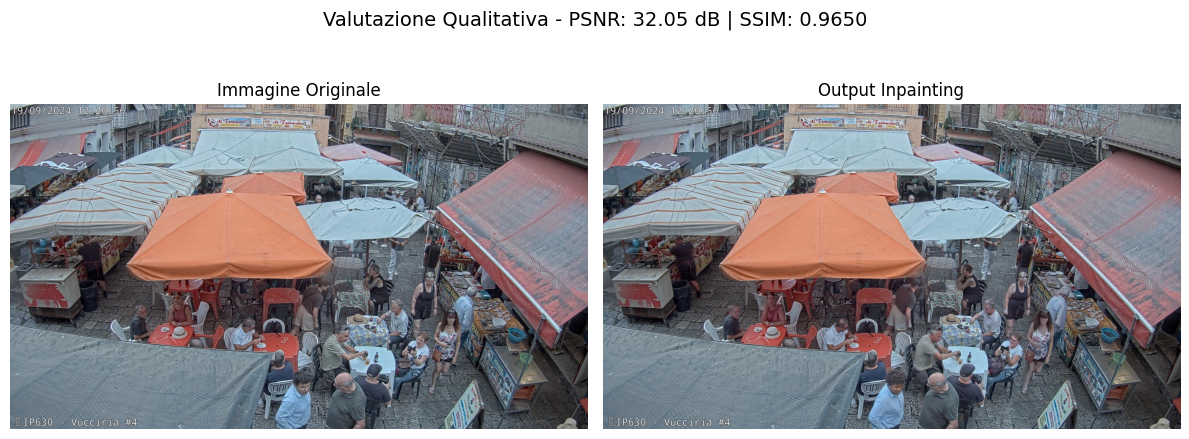

In [6]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Carica le immagini
original_img = np.array(Image.open(IMG_PATH).convert("RGB"))
inpainted_img = np.array(Image.open(OUT_PATH).convert("RGB"))

# Verifica dimensioni
assert original_img.shape == inpainted_img.shape, "Le immagini devono avere le stesse dimensioni"

# Calcolo delle metriche
psnr_value = psnr(original_img, inpainted_img, data_range=255)
ssim_value = ssim(original_img, inpainted_img, channel_axis=2, data_range=255)

print(f"🔍 PSNR: {psnr_value:.2f} dB")
print(f"🔍 SSIM: {ssim_value:.4f}")

# Plot per la tesi
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(original_img)
axs[0].set_title("Immagine Originale")
axs[0].axis("off")

axs[1].imshow(inpainted_img)
axs[1].set_title("Output Inpainting")
axs[1].axis("off")

plt.suptitle(f"Valutazione Qualitativa - PSNR: {psnr_value:.2f} dB | SSIM: {ssim_value:.4f}", fontsize=14)
plt.tight_layout()
plt.show()


In [9]:
import lpips
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === Caricamento immagini come PIL ===
img1_pil = Image.open(IMG_PATH).convert("RGB")
img2_pil = Image.open(OUT_PATH).convert("RGB")

# === Preprocessing LPIPS ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # LPIPS expects input in range [-1, 1]
])

img1_tensor = transform(img1_pil).unsqueeze(0).to(DEVICE)
img2_tensor = transform(img2_pil).unsqueeze(0).to(DEVICE)

# === Calcolo LPIPS ===
loss_fn = lpips.LPIPS(net='alex').to(DEVICE)
lpips_score = loss_fn(img1_tensor, img2_tensor).item()

print(f"🔍 LPIPS (perceptual similarity): {lpips_score:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
🔍 LPIPS (perceptual similarity): 0.0067


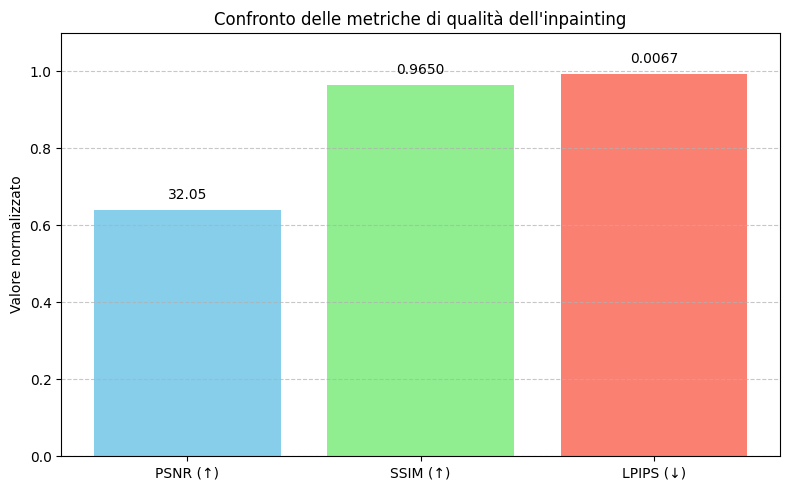

In [10]:
import matplotlib.pyplot as plt

# === Inserisci qui i tuoi valori ===
psnr_value = 32.05
ssim_value = 0.965
lpips_value = 0.0067

# === Valori e nomi normalizzati per visualizzazione ===
metriche = ['PSNR (↑)', 'SSIM (↑)', 'LPIPS (↓)']
valori = [psnr_value / 50, ssim_value, 1 - lpips_value]  # Normalizzazione per confronto visivo

# === Grafico ===
plt.figure(figsize=(8, 5))
bars = plt.bar(metriche, valori, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title("Confronto delle metriche di qualità dell'inpainting")
plt.ylabel("Valore normalizzato")

# Annotazioni sopra le barre
for bar, valore_originale in zip(bars, [psnr_value, ssim_value, lpips_value]):
    yval = bar.get_height()
    label = f"{valore_originale:.4f}" if valore_originale < 1 else f"{valore_originale:.2f}"
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, label, ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
from PIL import Image
import os

def convert_to_rgb_and_resize(folder, size=(256, 256)):
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder, fname)
            img = Image.open(path).convert("RGB").resize(size)
            img.save(path)

convert_to_rgb_and_resize("../images/original_crops")
convert_to_rgb_and_resize("../images/generated_crops")


In [16]:
from torch_fidelity import calculate_metrics

REAL_CROP_DIR = "../images/original_crops"
GEN_CROP_DIR = "../images/generated_crops"

metrics = calculate_metrics(
    input1=REAL_CROP_DIR,
    input2=GEN_CROP_DIR,
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=True
)

print(f"🔍 FID Score: {metrics['frechet_inception_distance']:.4f}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "../images/original_crops" with extensions png,jpg,jpeg
Found 16 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "../images/generated_crops" with extensions png,jpg,jpeg
Found 16 samples
Processing samples                                                      


🔍 FID Score: 243.6107


Frechet Inception Distance: 243.6107447059733


# Statistiche

  Categoria  Media  Minimo  Massimo  Deviazione Std
0   Persone  1.234    0.19     2.81        1.425037
1   Veicoli  1.750    0.30    11.19        3.290413


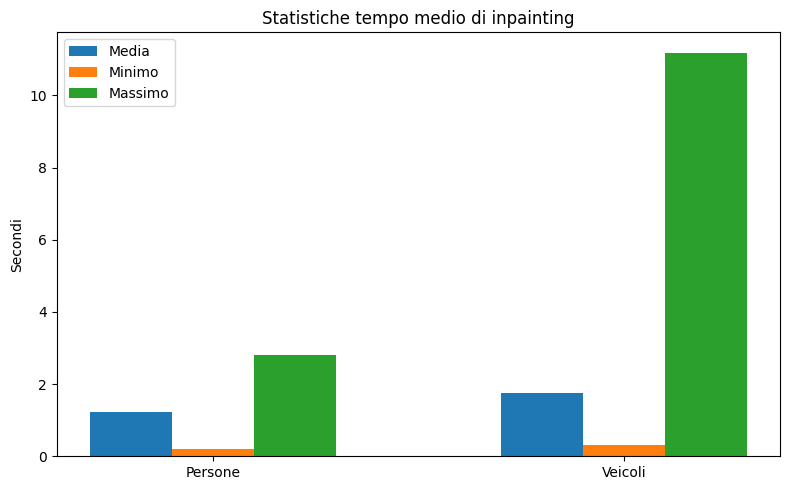

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i CSV
df_persone = pd.read_csv("../dataFrame/tempi_inpainting_custom_optimized_2.csv")
df_veicoli = pd.read_csv("../dataFrame/tempi_inpainting_custom_tot.csv")

# Funzione per estrarre statistiche da una colonna specifica
def compute_stats(df, col_name, label):
    times = df[col_name]
    return {
        "Categoria": label,
        "Media": times.mean(),
        "Minimo": times.min(),
        "Massimo": times.max(),
        "Deviazione Std": times.std()
    }

# Calcola le statistiche per ciascun dataset
stats = [
    compute_stats(df_persone, "Tempo Medio Inpainting/Persona (s)", "Persone"),
    compute_stats(df_veicoli, "Tempo Medio Inpainting/Oggetto (s)", "Veicoli")
]

# Crea un DataFrame con le statistiche
stats_df = pd.DataFrame(stats)
print(stats_df)

# Grafico a barre
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.2
x = range(len(stats_df))

# Traccia le barre
ax.bar(x, stats_df["Media"], width=bar_width, label="Media")
ax.bar([i + bar_width for i in x], stats_df["Minimo"], width=bar_width, label="Minimo")
ax.bar([i + 2 * bar_width for i in x], stats_df["Massimo"], width=bar_width, label="Massimo")
ax.set_xticks([i + bar_width for i in x])
ax.set_xticklabels(stats_df["Categoria"])
ax.set_ylabel("Secondi")
ax.set_title("Statistiche tempo medio di inpainting")
ax.legend()

plt.tight_layout()
plt.show()


# TensortRT

In [2]:
import os
import time
import torch
import torch._dynamo  # importa torch._dynamo per gestire errori
torch._dynamo.config.suppress_errors = True
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import cProfile
import pstats
from io import StringIO
from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline_optimized as pipeline

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = DEVICE == "cuda"
#USE_FP16 = False
USE_TORCH_COMPILE = DEVICE == "cuda" and hasattr(torch, 'compile')
COMPILE_MODE = "reduce-overhead"
N_INFERENCE_STEPS = 20
BATCH_SIZE_INPAINT = 4
USE_TENSORRT = True

print(f"[INFO] Using device: {DEVICE}")
print(f"[INFO] Using FP16 precision: {USE_FP16}")
print(f"[INFO] Using torch.compile: {USE_TORCH_COMPILE} (mode: {COMPILE_MODE})")
print(f"[INFO] Inpainting steps: {N_INFERENCE_STEPS}, batch size: {BATCH_SIZE_INPAINT}")

# === Paths ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting_optimized_2.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_optimized_3.csv"
MODEL_DATA_DIR = "../data"
YOLO_MODEL_NAME = "yolov8x-seg.pt"
models_name = {
                "INPAINTING_MODEL_NAME": "v1-5-pruned-emaonly-fp16.ckpt",
                "TENSORTRT_MODEL_NAME": "diffusion.engine"
              }

REAL_CROP_DIR = "../images/original_crops"
GEN_CROP_DIR = "../images/generated_crops"

os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

os.makedirs(REAL_CROP_DIR, exist_ok=True)
os.makedirs(GEN_CROP_DIR, exist_ok=True)

# === Profilazione globale ===
pr = cProfile.Profile()
pr.enable()
start_total = time.time()

# === Load models ===
print("[INFO] Loading models...")
tokenizer = CLIPTokenizer(
    os.path.join(MODEL_DATA_DIR, "vocab.json"),
    merges_file=os.path.join(MODEL_DATA_DIR, "merges.txt")
)

models_file = {
                "INPAINTING_MODEL_NAME": os.path.join(MODEL_DATA_DIR, models_name["INPAINTING_MODEL_NAME"]),
                "TENSORTRT_MODEL_NAME": os.path.join(MODEL_DATA_DIR, models_name["TENSORTRT_MODEL_NAME"])
              }

if not os.path.exists(models_file["INPAINTING_MODEL_NAME"]):
    raise FileNotFoundError(f"Model checkpoint not found at {model_file['INPAINTING_MODEL_NAME']}")

if USE_TENSORRT and not os.path.exists(models_file["TENSORTRT_MODEL_NAME"]):
    raise FileNotFoundError(f"Model checkpoint not found at {models_name['TENSORTRT_MODEL_NAME']}")

print(models_file['TENSORTRT_MODEL_NAME'])
models = model_loader.preload_models_from_standard_weights(models_file, DEVICE, USE_TENSORRT)

for model_name, model in models.items():
    if model is None:
        continue

    use_trt_for_this = USE_TENSORRT and model_name == "diffusion"
    if not use_trt_for_this:
        model.to(DEVICE)
        if USE_FP16:
            model = model.half()

        if USE_TORCH_COMPILE and model_name in ["encoder", "decoder", "diffusion"]:
            try:
                print(f"[INFO] Compiling {model_name} with torch.compile...")
                model = torch.compile(model, mode=COMPILE_MODE)
            except Exception as e:
                print(f"[WARNING] Failed to compile {model_name}, using eager mode instead. Error:\n{e}")
                import torch._dynamo
                torch._dynamo.config.suppress_errors = True  # fallback automatico
    else:
        print(f"[INFO] Using TensorRT engine for {model_name}, skipping PyTorch compile.")

    models[model_name] = model


# === Load image ===
if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image not found at {IMG_PATH}")
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === YOLOv8 segmentation ===
print("[INFO] Running YOLOv8 segmentation...")
if not os.path.exists(YOLO_MODEL_NAME):
    raise FileNotFoundError(f"YOLO model not found at {YOLO_MODEL_NAME}")
yolo_model = YOLO(YOLO_MODEL_NAME)
start_yolo = time.time()
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0
all_crops_data = []

# === Crop and Mask Extraction ===
start_crop = time.time()
for result in results:
    if result.masks is None:
        continue

    boxes = result.boxes
    masks_yolo = result.masks

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks_yolo.data[i].cpu().numpy().astype(np.uint8)
        mask_resized_full = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

        contours, _ = cv2.findContours(mask_resized_full, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled_full_for_crop = np.zeros_like(mask_resized_full)
        cv2.drawContours(mask_filled_full_for_crop, contours, -1, 255, thickness=cv2.FILLED)

        mask_crop_np = mask_filled_full_for_crop[y1:y2, x1:x2]
        if mask_crop_np.sum() / 255 < 200:
            continue

        crop_img_pil = original_img.crop((x1, y1, x2, y2))

        crop_index = len(all_crops_data)
        real_crop_path = os.path.join(REAL_CROP_DIR, f"real_crop_{crop_index:03}.png")
        crop_img_pil.save(real_crop_path)

        crop_mask_pil = Image.fromarray(mask_crop_np).convert("L")

        resized_img_pil = crop_img_pil.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask_pil = crop_mask_pil.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        all_crops_data.append({
            'input_image': resized_img_pil,
            'input_mask': resized_mask_pil,
            'prompt': prompt,
            'negative_prompt': negative_prompt,
            'coords': {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'box_w': box_w, 'box_h': box_h},
            'original_crop_pil': crop_img_pil,
            'blend_mask_pil': Image.fromarray(mask_crop_np).convert("L")
        })
crop_time = time.time() - start_crop

# === Inpainting ===
if all_crops_data:
    num_batches = (len(all_crops_data) + BATCH_SIZE_INPAINT - 1) // BATCH_SIZE_INPAINT
    print(f"[INFO] Processing {len(all_crops_data)} people in {num_batches} batches...")

    for batch_num in range(num_batches):
        batch_start_idx = batch_num * BATCH_SIZE_INPAINT
        batch_end_idx = min((batch_num + 1) * BATCH_SIZE_INPAINT, len(all_crops_data))
        current_batch_data = all_crops_data[batch_start_idx:batch_end_idx]

        batched_input_images = [item['input_image'] for item in current_batch_data]
        batched_input_masks = [item['input_mask'] for item in current_batch_data]
        batched_prompts = [item['prompt'] for item in current_batch_data]
        batched_neg_prompts = [item['negative_prompt'] for item in current_batch_data]

        start_inpaint = time.time()
        generated = pipeline.generate(
            prompt=batched_prompts,
            uncond_prompt=batched_neg_prompts,
            input_image=batched_input_images,
            input_mask=batched_input_masks,
            strength=0.4,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=N_INFERENCE_STEPS,
            seed=None,
            models=models,
            device=DEVICE,
            tokenizer=tokenizer,
            use_fp16=USE_FP16,
            use_tensorrt=USE_TENSORRT
        )
        inpaint_total_time += (time.time() - start_inpaint)

        for i, result_np in enumerate(generated):
            item_data = current_batch_data[i]
            result_pil = Image.fromarray(result_np)

            gen_crop_path = os.path.join(GEN_CROP_DIR, f"gen_crop_{batch_start_idx + i:03}.png")
            result_pil.save(gen_crop_path)


            coords = item_data['coords']
            original_crop_pil = item_data['original_crop_pil']
            blend_mask_pil = item_data['blend_mask_pil']

            result_resized = result_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.LANCZOS)
            result_np = np.array(result_resized).astype(np.float32)
            original_np = np.array(original_crop_pil).astype(np.float32)

            blend_mask = np.array(blend_mask_pil.resize((coords['box_w'], coords['box_h']), resample=Image.Resampling.NEAREST)).astype(np.float32) / 255.0
            blend_mask = np.expand_dims(blend_mask, axis=-1)

            blended = result_np * blend_mask + original_np * (1 - blend_mask)
            final_img_np[coords['y1']:coords['y2'], coords['x1']:coords['x2']] = blended.astype(np.uint8)
            crop_counter += 1
else:
    print("[INFO] No valid people found for inpainting.")

# === Save final output ===
final_img_pil = Image.fromarray(final_img_np)
final_img_pil.save(OUT_PATH)
print(f"[INFO] Output image saved to: {OUT_PATH}")

# === Save performance CSV ===
total_time = time.time() - start_total
if crop_counter > 0:
    df_data = {
        # "Modello": f"YOLOv8 + SD 1.5 (Steps:{N_INFERENCE_STEPS} FP16:{USE_FP16} Compile:{USE_TORCH_COMPILE} Batch:{BATCH_SIZE_INPAINT})",
        "Segmentation model": YOLO_MODEL_NAME.split('.')[0],
        "Inpainting model": models_name["INPAINTING_MODEL_NAME"].split('.')[0],
        "Device": DEVICE,
        "TensorRT": USE_TENSORRT,
        "Inference steps": N_INFERENCE_STEPS,
        "Batch size":BATCH_SIZE_INPAINT,
        "Tempo Segmentazione (s)": round(yolo_time, 2),
        "Tempo Estrazione Crop (s)": round(crop_time, 2),
        "Tempo Inpainting Totale (s)": round(inpaint_total_time, 2),
        "Tempo Totale Script (s)": round(total_time, 2),
        "Persone Elaborate": crop_counter,
        "Tempo Medio Inpainting/Persona (s)": round(inpaint_total_time / crop_counter, 2)
    }
    df = pd.DataFrame([df_data])
    if os.path.exists(CSV_PATH):
        try:
            df_old = pd.read_csv(CSV_PATH)
            df = pd.concat([df_old, df], ignore_index=True)
        except Exception as e:
            print(f"[WARNING] Errore nel CSV esistente: {e}. Sovrascrivo.")
    df.to_csv(CSV_PATH, index=False)
    print(f"[INFO] Performance data saved to: {CSV_PATH}")
    print(df)

# === Profilazione finale ===
pr.disable()
s = StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats(pstats.SortKey.CUMULATIVE)
ps.print_stats(20)  # Mostra le 20 funzioni più lente
print(s.getvalue())

print(f"[✅] {crop_counter} persone elaborate.")
print("[INFO] Script completato.")


[INFO] Using device: cuda
[INFO] Using FP16 precision: True
[INFO] Using torch.compile: True (mode: reduce-overhead)
[INFO] Inpainting steps: 20, batch size: 4
[INFO] Loading models...
../data/diffusion.engine
[INFO] Compiling encoder with torch.compile...
[INFO] Compiling decoder with torch.compile...
[INFO] Using TensorRT engine for diffusion, skipping PyTorch compile.
[INFO] Running YOLOv8 segmentation...
[INFO] Processing 16 people in 4 batches...
[06/24/2025-16:45:51] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[INFO] Output image saved to: ../images/output_custom_inpainting_optimized_2.jpg
[INFO] Performance data saved to: ../dataFrame/tempi_inpainting_custom_optimized_3.csv
   Segmentation model          Inpainting model Device  TensorRT  \
0         yolov8x-seg  v1-5-pruned-emaonly-fp16   cuda     False   
1   